In [65]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import brentq

sns.set_style('darkgrid')

In [66]:
# helper function 
def bs_call(S0, K, sigma, t, r = 0):
    """
    Computes the Black-Scholes price of a European call option.

    Parameters:
        S0 (float): Current asset price
        K (float): Strike price
        sigma (float): Annualized volatility (standard deviation of log returns)
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate (annualized)

    Returns:
        float: Call option price
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    call_price = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    return call_price

def bs_call_delta(S0, K, sigma, t, r):
    """
    Returns the Delta (sensitivity to spot price) of a European call option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Call Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1)

def bs_MC_call_delta(S0, K, sigma, t, r, delta_sims = int(250)):
    """Description: 
    Monte-Carlo Simulation of Black-Scholes Call Delta
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (float): volatility
    t (float): time to expiration
    r (float): risk-free interest rate
    delta_sims (int): Number of simulations
    
    Return
    float: simulated delta of call option
    
    """
    bump = .01*S0 #epsilon in above estimation

    noise = np.random.normal(0,1,delta_sims)

    log_returns = (r-.5*sigma**2)*t + sigma*np.sqrt(t)*noise

    paths_up = (S0+bump)*np.exp(log_returns)

    paths_down = (S0-bump)*np.exp(log_returns)

    calls_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)

    calls_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)

    delta_sims = (calls_up - calls_down)/(2*bump)


    delta_estimate = np.mean(delta_sims)

    return delta_estimate

def bs_MC_call_delta_array(S, K, sigma, t, r, delta_sims = 250):
    """Description: 
    Monte-Carlo Simulation of Black-Scholes Call Deltas in an array
    
    Parameters:
    S (np.array of floats): spot prices
    K (float): strike price
    sigma (float): volatility
    t (float): time to expiration
    r (float): risk-free interest rate
    delta_sims (int): Number of simulations
    
    Return
    float: simulated delta of call option
    
    """
    
    bump = .01*S #epsilon in above estimation

    noise = np.random.normal(0,1,(delta_sims,len(S)))

    log_returns = (r-.5*sigma**2)*t + sigma*np.sqrt(t)*noise

    paths_up = (S+bump)*np.exp(log_returns)

    paths_down = (S-bump)*np.exp(log_returns)

    calls_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)

    calls_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)

    delta_sims = (calls_up - calls_down)/(2*bump)


    delta_estimate = np.mean(delta_sims, axis=0)
    

    return delta_estimate

def gbm_path_sim(S0, sigma, t, r, mu= 0, n_sims = 1, n_steps = 1):
    """
    Simulation of stock path movements as Geometric Brownian Motion.
    
    Parameters:
    - S0 (float): Initial stock price
    - sigma (float): yearly volatility
    - t (float): Total time horizon (in years)
    - r (float): Risk-free interest rate
    - mu (float): Excess drift of log-returns
    - n_steps (int): Number of time steps
    - n_sims (int): Number of simulated paths

    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    """
    
    dt = t/n_steps
    
    noise = np.random.normal(0,1,size = (n_sims, n_steps))
    
    increments_log_returns = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    log_returns = np.cumsum(increments_log_returns, axis = 1)
    
    paths = S0*np.exp(log_returns)
    
    paths = np.insert(paths, 0, S0, axis = 1)
   
    return paths

def bs_MC_call_hedge(S0, K, sigma, t, r, mu = 0, n_sims = 2500, n_hedges = 50, delta_sims = 250):
    
    """Description
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta based control variants
    
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (float): volatility
    r (float): risk-free interest rate
    t (float): time to expiration
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments
    
    
    Return:
    np.array of simulated values of Black-Scholes value of call option
    """
    noise = np.random.normal(0,1,(n_sims,n_hedges))


    #time interval between each step in simulated path
    dt = t/n_hedges

    increments = (mu+r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise #log_return increments

    log_returns = np.cumsum(increments, axis = 1)

    paths = S0*np.exp(log_returns)



    #Simulate call payouts discounted to time 0

    path_end_points = paths[:,-1]

    call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)



    #Simulate stock profits at each interval

    ## profit from start to first step discounted to time 0
    ### We are going to cheat at the current moment in our simulation
    ### We will use the Black-Scholes formula to find Delta,
    ### We'll simulate Delta later

    delta_start = bs_MC_call_delta(S0,K,sigma,t,r,delta_sims)

    paths_first_steps = paths[:,0]

    first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*delta_start*np.exp(-dt*r)

    stock_profits = []

    stock_profits.append(first_stock_profits)




    ## stock profits in intermediate steps

    for i in range(1,n_hedges):
        stock_start = paths[:,i-1]
        stock_end = paths[:,i]
        tte = t-i*dt
        deltas = bs_MC_call_delta_array(stock_start, K, sigma, tte, r,delta_sims)


        stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)


        stock_profits.append(stock_profit)


    total_stock_profit = np.sum(stock_profits, axis = 0)

    profits_hedged = call_payouts - total_stock_profit
    
    
    return profits_hedged

def heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=1, mu=0, return_vol=False):
    """
    Simulation of stock path movements under the Heston stochastic volatility model.
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    - vols (ndarray, optional): Simulated variance paths if return_vol is True
    """
    dt = t / n_steps
    N1 = np.random.normal(0, 1, size=(n_sims, n_steps))
    N2 = np.random.normal(0, 1, size=(n_sims, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths = np.zeros((n_sims, n_steps + 1))
    vols = np.zeros((n_sims, n_steps + 1))
    paths[:, 0] = S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
                                xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
    
    return (paths, vols) if return_vol else paths


def heston_call_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=2500, mu=0):
    """
    Monte-Carlo Simulation of Call Option under Heston model with Black-Scholes Delta control variates
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - call_payouts (ndarray): Simulated payouts of a call-option
    """
    
    
    paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu, return_vol=True)
    
    dt = t / n_steps

    # Compute BS deltas from previous steps volatility across all steps (n_steps, n_sims)
    # This is only an approximation of Delta of call option under Heston model.
    # The black-scholes deltas and Heston deltas are correlated enough so that black-scholes deltas
    # still work as a control variate in Monte-Carlo Simulation of Heston model option pricing
    
    deltas = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T  
    
    # Stock P&L from delta hedge
    stock_profits_steps = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * deltas * np.exp(-r * np.arange(1, n_steps + 1) * dt)
    stock_profits = np.sum(stock_profits_steps, axis=1)

    # Call payouts
    call_payouts = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    # Adjusted estimator
    call_payouts_hedged = call_payouts - stock_profits

    return call_payouts_hedged


def implied_volatility_call(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a call option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        return bs_call(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan

# Non-constant varaince stock movement --  a naive approch
In the classific Black-Scholes model, the volatility of th stock moevemnt is assume to be constant $\sigma$. One simplt approch to investigate the non-constant voliatility can be introducing varaince $\sigma^2$ as random varaible from a simple uniform discrite distribution for different time segment. Let the spot price is $S(0)$, strike price is $K$ and time to expiration is $t$. Suppose we have $n$ intermediate time steps such that $0<t_1<t_2<\cdots<t_n<t$. For each time intervale $[t_{i-1}, t_i]$, the stock price is model with geometric brownian motion with varaince $\sigma$ from a random distribution. 

We first make a naive approch by sampling the volatility as
$$
\sigma=\left\{\begin{aligned}
&0.45,&p=0.2\\
&0.3,&p=0.3\\
&0.2,&p=0.5\\
\end{aligned}\right.
$$

In [67]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    """
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.

    Each step of the log-returns, there is a
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45

    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path

    Returns:

    Simuatled stock paths and variance for each steps
    """

    # Noise in volatility
    noise = np.random.normal(0, 1, size=(n_paths, n_steps))

    # Custom sigma that is not constant
    sigma = np.random.choice(
        [0.2, 0.3, 0.45], p=[0.5, 0.3, 0.2], size=(n_paths, n_steps)
    )

    # Time increment between each step
    dt = t / n_steps

    # log-returns between each step
    increments = (mu + r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * noise

    # Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis=1)

    # paths
    paths = S0 * np.exp(log_returns)

    # Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis=1)

    return paths, sigma**2

## Stock path simulation

In [ ]:
S0 = 178.2
sigma = 0.3
t = 1
r = 0.039
mu = 0.034
n_steps = 252
n_paths = 10

# stock path from Geometric Brownian Motion
bs_path = gbm_path_sim(S0, sigma, t, r, mu, n_paths, n_steps)

# stock path with non-constant varaince
non_constant_path, _= stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


Text(0.5, 1.0, 'Stock path simulation with naive approach for non-constant variance')

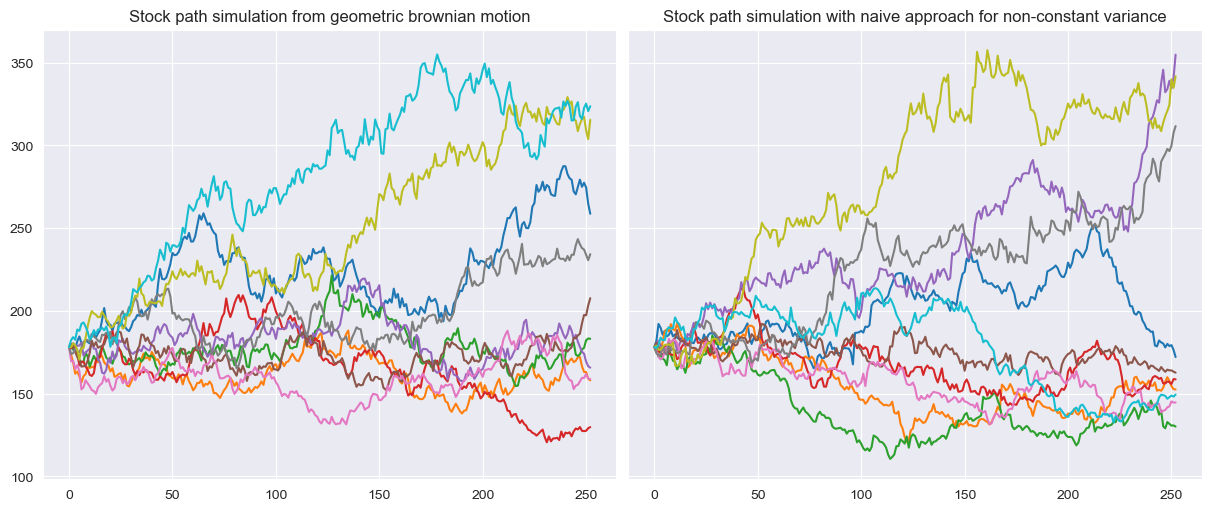

In [69]:
fig1, axs1 = plt.subplots(1, 2, figsize=[12, 5], layout='constrained', sharey=True, sharex=True)
axs1[0].plot(bs_path.T)
axs1[0].set_title('Stock path simulation from geometric brownian motion')
axs1[1].plot(non_constant_path.T)
axs1[1].set_title('Stock path simulation with naive approach for non-constant variance')

Next we need to find the corresponding call option price and hedged price for the non-constant variance model we build

In [ ]:
def custom_call(S0, K, r, mu, t, n_steps, n_sims = 2500):
    # simulate stock path
    paths, _ = stock_path_custom_sigma(S0, t, r, mu, n_sims, n_steps)
    # call price
    call_payout = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)
    return call_payout



def custom_call_hedge(S0, K, r, mu, t, n_hedge, n_sims=2500):
    
    # simulate path using variance-change GBM
    paths, vols = stock_path_custom_sigma(S0, t, r, mu, n_sims, n_hedge)

    dt = t / n_hedge
    
    # find delats at the begin of each interval
    deltas = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:, i]), t - i * dt, r) for i in range(n_hedge)]).T

    # Stock P&L from delta hedge
    stock_profits_steps = (paths[:, 1:] - np.exp(r * dt) * paths[:, :-1]) * deltas * np.exp(-r * np.arange(1, n_hedge + 1) * dt)
    stock_profits = np.sum(stock_profits_steps, axis=1)

    # Call payouts
    call_payout = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    call_payout_hedge = call_payout - stock_profits

    return call_payout_hedge

## Call option price

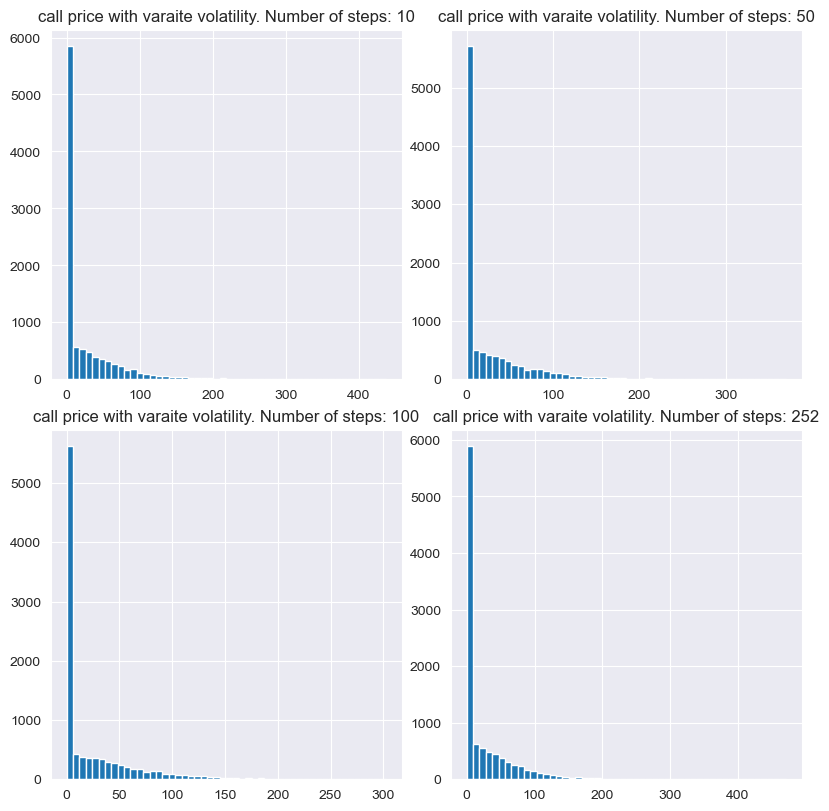

In [71]:
K = 185
steps_list = [10, 50, 100, 252]
fig2, axs2 = plt.subplots(2, 2, figsize=[8, 8], layout='constrained')
for ax, steps in zip(axs2.flat, steps_list):
    custom_call_price = custom_call(S0, K, r, mu, t, steps, n_sims=10000)
    ax.hist(custom_call_price, bins=50)
    ax.set_title(f"call price with varaite volatility. Number of steps: {steps}")

We then perform delta hedging at each steps

Text(0.5, 0.98, 'Call option pirce with non-constant volatility')

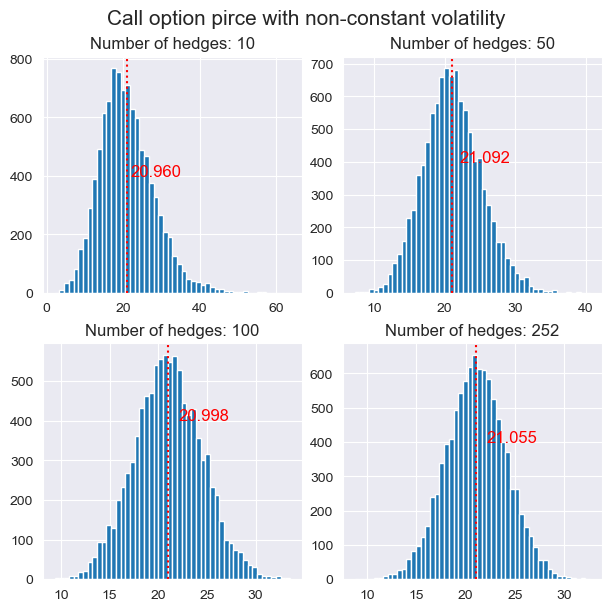

In [90]:
fig3, axs3 = plt.subplots(2, 2, figsize=[6, 6], layout='constrained')
for ax, steps in zip(axs3.flat, steps_list):
    custom_call_price = custom_call_hedge(S0, K, r, mu, t, n_hedge=steps, n_sims=10000)
    custom_call_price_mean = np.mean(custom_call_price)
    ax.hist(custom_call_price, bins=50)
    ax.axvline(custom_call_price_mean, linestyle=':', color='r')
    ax.text(x=custom_call_price_mean * 1.05, y=400, s=f'{custom_call_price_mean:.3f}', color='r', fontsize=12)
    ax.set_title(f"Number of hedges: {steps}")

fig3.suptitle('Call option pirce with non-constant volatility', fontsize=15)

Noticed that the hedging process converge pretty fast. We can compare that with what the original Black-Scholes call option price

Text(0.5, 0.98, 'Call price with GBM after hedging')

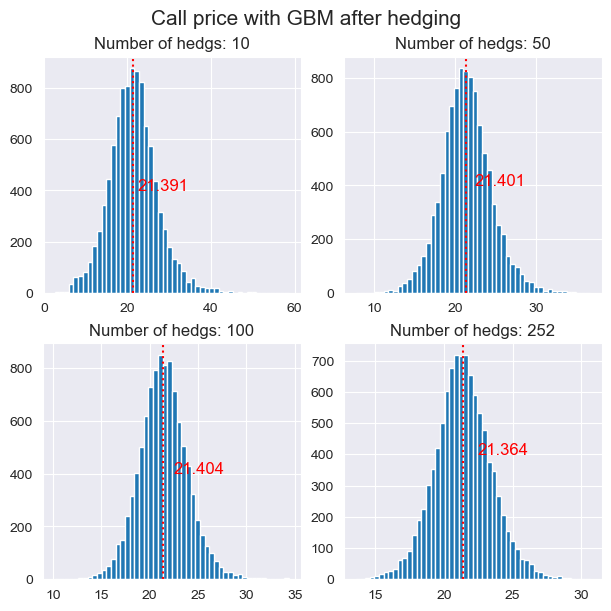

In [92]:
fig4, axs4 = plt.subplots(2, 2, figsize=[6, 6], layout='constrained')
for ax, steps in zip(axs4.flat, steps_list):
    bs_call_price = bs_MC_call_hedge(S0, K, sigma, t, r, mu, n_sims=10000, n_hedges=steps)
    ax.hist(bs_call_price, bins=50)
    bs_call_price_mean = np.mean(bs_call_price)
    ax.axvline(bs_call_price_mean, linestyle=':', color='r')
    ax.text(x=bs_call_price_mean * 1.05, y=400, s=f'{bs_call_price_mean:.3f}', color='r', fontsize=12)
    ax.set_title(f"Number of hedgs: {steps}")

fig4.suptitle('Call price with GBM after hedging', fontsize=15)

The call option price is very similar between this two model.

## Check the historical volatility of the two methods

Text(0.5, 1.0, 'Simulated Historical Volatilities of non-constant volatility simulated stock paths')

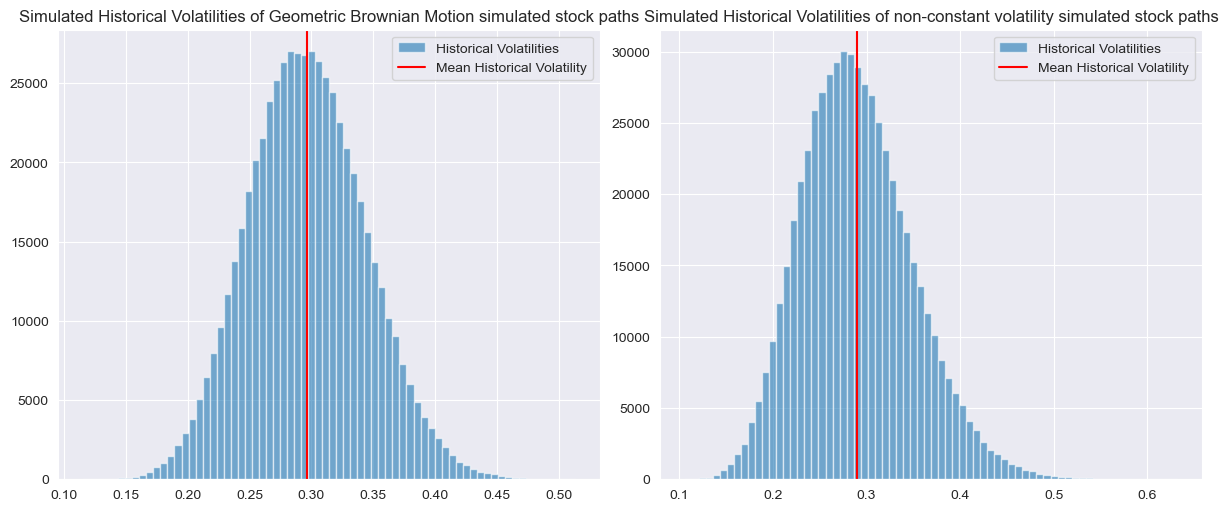

In [74]:
bs_path = gbm_path_sim(S0, sigma, t, r, mu, 2500, n_steps)

non_constant_path, _= stock_path_custom_sigma(S0, t, r, mu, 2500, n_steps)

#Convert simulated paths to pandas series
bs_path = [pd.Series(path) for path in bs_path]
non_constant_path = [pd.Series(path) for path in non_constant_path]


# Compute 21-day volatilities of paths
bs_path_rolling_vols = [np.log(path/path.shift(1)).rolling(window=21).std()*np.sqrt(252) for path in bs_path]
non_constant_path_rolling_vols = [np.log(path/path.shift(1)).rolling(window=21).std()*np.sqrt(252) for path in non_constant_path]

#Concatenate the rolling volatilities of the simulated paths
bs_all_rolling_vols = pd.concat(bs_path_rolling_vols, ignore_index=True).dropna()
non_constant_all_rolling_vols = pd.concat(non_constant_path_rolling_vols, ignore_index=True).dropna()

#Create Histogram of volatilities
fig5, axs5 = plt.subplots(1, 2, figsize=[12, 5], layout='constrained')
axs5[0].hist(bs_all_rolling_vols, bins = 70, alpha = .6, label = 'Historical Volatilities')
axs5[0].axvline(np.mean(bs_all_rolling_vols), color = 'red', label = 'Mean Historical Volatility')
axs5[0].legend()
axs5[0].set_title('Simulated Historical Volatilities of Geometric Brownian Motion simulated stock paths')
axs5[1].hist(non_constant_all_rolling_vols, bins = 70, alpha = .6, label = 'Historical Volatilities')
axs5[1].axvline(np.mean(non_constant_all_rolling_vols), color = 'red', label = 'Mean Historical Volatility')
axs5[1].legend()
axs5[1].set_title('Simulated Historical Volatilities of non-constant volatility simulated stock paths')


# Non-constant variance model with normal distribution
The naive approach we investigate above only all for three possible variance value. The resulting call option price distribution is very similar to that of constant variance. We can further extend the model by sampled the stock volatility from a normal distribution
$$
v_t=v_0 + \xi\mathcal{N}(0, 1)
$$
Here, $v_0$ is the initial variance and $\xi$ is the parameter control the volatility of the stock price volatility distribution.

In [75]:
def stock_path_normal_sigma(S0, t, r, mu, v0, xi, n_paths, n_steps):
    """
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.

    Each step of the log-returns, there is a
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45

    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path

    Returns:

    Simuatled stock paths and variance for each steps
    """

    # Noise in volatility
    noise = np.random.normal(0, 1, size=(n_paths, n_steps))

    # Custom sigma that is not constant
    vols = np.abs(v0 + np.random.normal(0, 1, size=(n_paths, n_steps)) * xi)


    # Time increment between each step
    dt = t / n_steps

    # log-returns between each step
    increments = (mu + r - 0.5 * vols) * dt + np.sqrt(vols) * np.sqrt(dt) * noise

    # Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis=1)

    # paths
    paths = S0 * np.exp(log_returns)

    # Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis=1)

    return paths, vols

def custom_normal_call_hedge(S0, K, r, mu, t, v0, xi, n_hedge, n_sims=2500):
    
    # simulate path using variance-change GBM
    paths, vols = stock_path_normal_sigma(S0, t, r, mu, v0, xi, n_sims, n_hedge)

    dt = t / n_hedge

    deltas = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:, i]), t - i * dt, r) for i in range(n_hedge)]).T

    # Stock P&L from delta hedge
    stock_profits_steps = (paths[:, 1:] - np.exp(r * dt) * paths[:, :-1]) * deltas * np.exp(-r * np.arange(1, n_hedge + 1) * dt)
    stock_profits = np.sum(stock_profits_steps, axis=1)

    # Call payouts
    call_payout = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    call_payout_hedge = call_payout - stock_profits

    return call_payout_hedge, vols

## Call option price

We again first check the hedging convergence

Text(0.5, 0.98, 'Call price with normally distributed volatility')

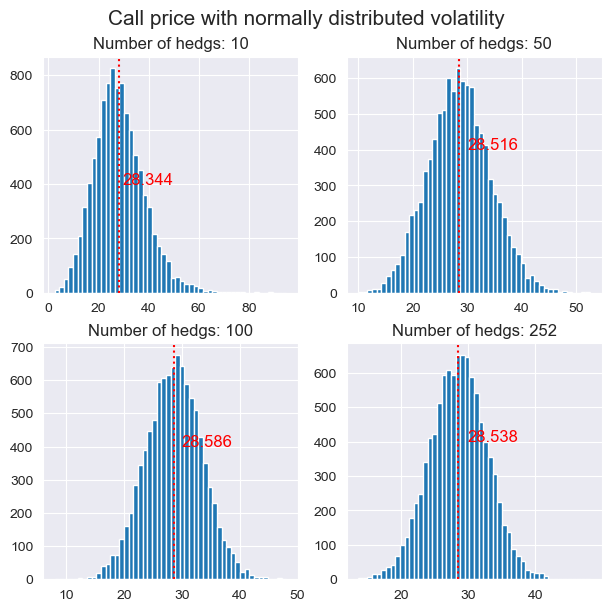

In [104]:
S0 = 178.2
t = 1
r = 0.039
mu = 0.034
n_steps = 252
xi = 0.2
v0 = 0.2 ** 2
fig6, axs6 = plt.subplots(2, 2, figsize=[6, 6], layout='constrained')
for ax, steps in zip(axs6.flat, steps_list):
    custom_normal_call_price, vols = custom_normal_call_hedge(S0, K, r, mu, t, v0, xi, n_hedge=steps, n_sims=10000)
    custom_normal_call_price_mean = np.mean(custom_normal_call_price)
    ax.hist(custom_normal_call_price, bins=50)
    ax.axvline(custom_normal_call_price_mean, linestyle=':', color='r')
    ax.text(x=custom_normal_call_price_mean * 1.05, y=400, s=f'{custom_normal_call_price_mean:.3f}', color='r', fontsize=12)
    ax.set_title(f"Number of hedgs: {steps}")
fig6.suptitle("Call price with normally distributed volatility", fontsize=15)

Noticed that the average call price after hedging is larger comparing to that in the GBM and our naive approach. Next, we investigate the effect on the volatility of stock volatility distribution

Text(0.5, 0.98, 'Call price with normally distributed volatility')

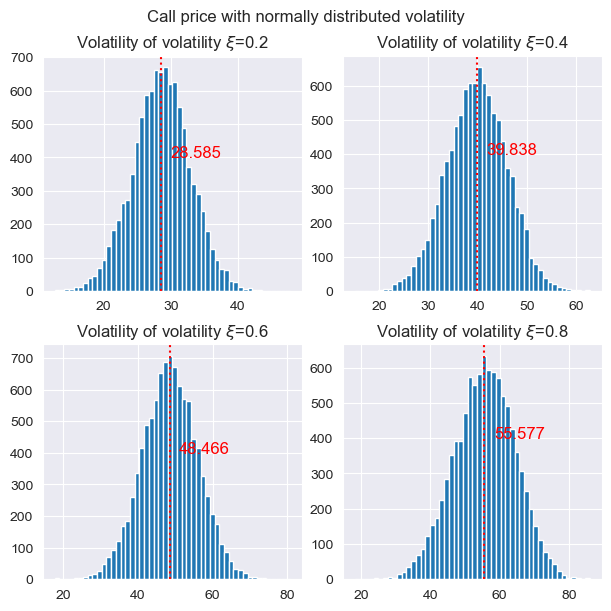

In [94]:
xis = [0.2, 0.4, 0.6, 0.8]
fig7, axs7 = plt.subplots(2, 2, figsize=[6, 6], layout='constrained')
for ax, x in zip(axs7.flat, xis):
    custom_normal_call_price, _ = custom_normal_call_hedge(S0, K, r, mu, t, v0, x, n_hedge=steps, n_sims=10000)
    custom_normal_call_price_mean = np.mean(custom_normal_call_price)
    ax.hist(custom_normal_call_price, bins=50)
    ax.axvline(custom_normal_call_price_mean, linestyle=':', color='r')
    ax.text(x=custom_normal_call_price_mean * 1.05, y=400, s=f'{custom_normal_call_price_mean:.3f}', color='r', fontsize=12)
    ax.set_title(f"Volatility of volatility $\\xi$={x}")
fig7.suptitle("Call price with normally distributed volatility", fontsize=12)

The simulated call option price change dramatically as the volatility $\xi$ increase, meaning the model we set up is very sensitive to the parameters

Text(0.5, 1.0, 'Historical Volatilities of normal volatility stock paths')

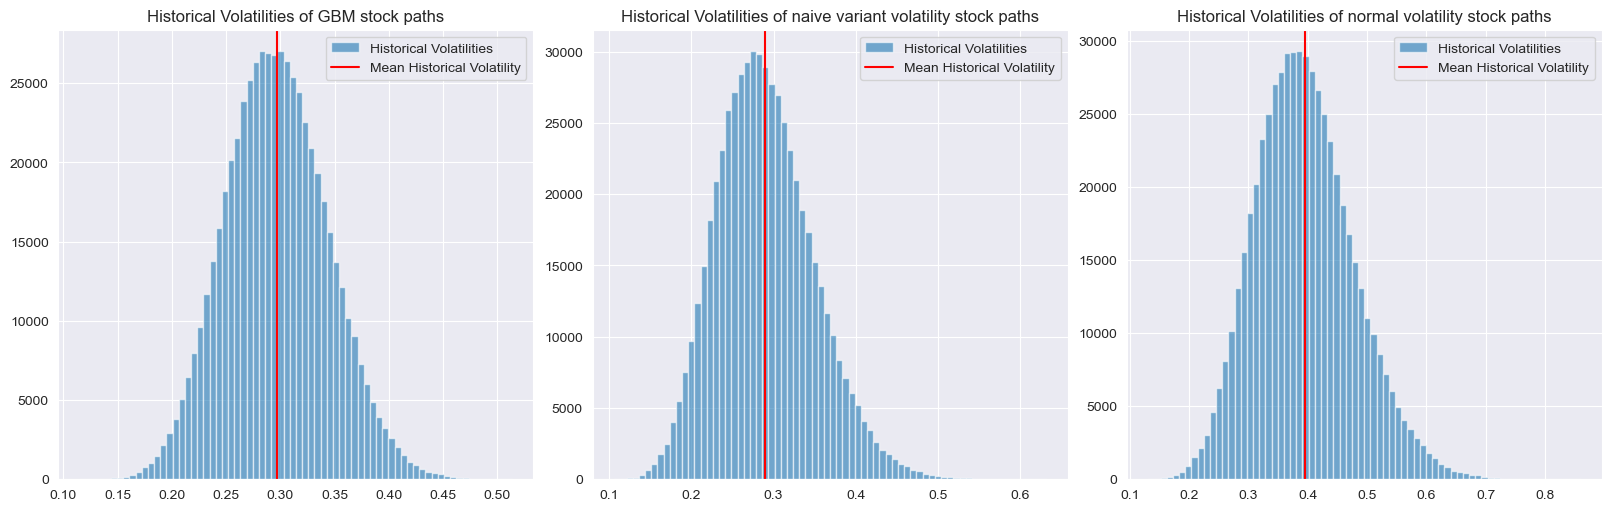

In [101]:
non_constant_normal_path, _ = stock_path_normal_sigma(S0, t, r, mu, v0, xi, 2500, n_steps)

# Convert simulated paths to pandas series
non_constant_normal_path = [pd.Series(path) for path in non_constant_normal_path]

# Compute 21-day volatilities of paths
non_constant_norma_path_rolling_vols = [
    np.log(path / path.shift(1)).rolling(window=21).std() * np.sqrt(252)
    for path in non_constant_normal_path
]


# Concatenate the rolling volatilities of the simulated paths
non_constant_normal_all_rolling_vols = pd.concat(non_constant_norma_path_rolling_vols, ignore_index=True).dropna()

# Create Histogram of volatilities
fig8, axs8 = plt.subplots(1, 3, figsize=[16, 5], layout="constrained")
axs8[0].hist(bs_all_rolling_vols, bins=70, alpha=0.6, label="Historical Volatilities")
axs8[0].axvline(
    np.mean(bs_all_rolling_vols), color="red", label="Mean Historical Volatility"
)
axs8[0].legend()
axs8[0].set_title(
    "Historical Volatilities of GBM stock paths"
)
axs8[1].hist(non_constant_all_rolling_vols, bins=70, alpha=0.6, label="Historical Volatilities")
axs8[1].axvline(
    np.mean(non_constant_all_rolling_vols), color="red", label="Mean Historical Volatility"
)
axs8[1].legend()
axs8[1].set_title(
    "Historical Volatilities of naive variant volatility stock paths"
)
axs8[2].hist(
    non_constant_normal_all_rolling_vols, bins=70, alpha=0.6, label="Historical Volatilities"
)
axs8[2].axvline(
    np.mean(non_constant_normal_all_rolling_vols),
    color="red",
    label="Mean Historical Volatility",
)
axs8[2].legend()
axs8[2].set_title(
    "Historical Volatilities of normal volatility stock paths"
)


From the historical volatilizes comparison, we also find that the historical volatility from a normal variance is relatively higher than that with GBM and naive approach

## Heston model

The Heston model also sampled the volatility of stock from normal distribution, but with autoregressive feature. The Heston model with $n$ descrite time step can be formulated as follow.

Let $0 = t_0<t_1<\cdots <t_n = t$, then the $n$-step discrete Heston model assumes for each $1\leq i\leq n$ the variance of the log-returns at time $t_i$ is modeled as

$$v_{t_i} = |v_{t_{i-1}} + \kappa(\theta - v_{t_{i-1}})(t_i-t_{i-1}) + \xi\sqrt{v_{t_{i-1}}(t_i-t_{i-1})}\mathcal{N}^{v}(0,1)|$$

and the distribution of stock paths from time $t_{i-1}$ to $t_i$ is modeled as

$$S_{t_i} = S_{t_{i-1}}e^{(\mu + r - .5v_0)(t_i-t_{i-1}) + \sqrt{|v_{t_{i-1}}|(t_i-t_{i-1})}\mathcal{N}^S(0,1)}$$

where:

- $S_0$ is the initial stock price;
- $S_t$ is the stock price at time $t$;
- $v_0$ is the variance of the stock at time $0$;
- $v_t$ is the variance of the stock at time $t$;
- $\mu$ is the excess drift of the log-returns of the stock stock;
- $r$ is the risk-free interest rate;
- $\kappa$ is the mean-reversion rate of the variance process;
- $\theta$ is the long-run variance level of the variance process;
- $\xi$ is the volatility of volatility
- $\mathcal{N}^{v}(0,1)$ and $\mathcal{N}^{S}(0,1)$ are standard normal distributions with correlation $\rho$:

$$\rho = \mathrm{corr}\left(\mathcal{N}^{v}(0,1),\mathcal{N}^{S}(0,1)\right) = \frac{\mathrm{cov}(E\left[\mathcal{N}^{v}(0,1)\mathcal{N}^{S}(0,1))\right]}{\text{std}(\mathcal{N}^{v}(0,1))\mathrm{std}(\mathcal{N}^{S}(0,1))} = E\left[\mathcal{N}^{v}(0,1)\mathcal{N}^{S}(0,1))\right].$$


Text(0.5, 0.98, 'Call price from Heston model after hedging')

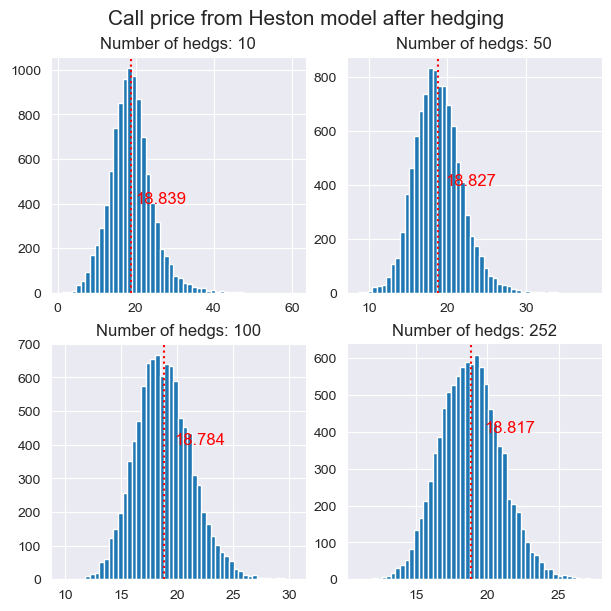

In [95]:
S0 = 178.2
kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)
theta = .3**2 #Long run variance of log-returns
xi = .2 # Volatility of Volatility (Typical range .2 to 1)
v0 = .2**2 #Initial variance of log-returns
rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)
t = 1 #Time horizon
n_steps = 252 #Number of steps in each simulation
r = .039 #Risk-free interest rate
mu = .034 #Excess drift of log returns

fig9, axs9 = plt.subplots(2, 2, figsize=[6, 6], layout='constrained')
for ax, steps in zip(axs9.flat, steps_list):
    heston_call_price = heston_call_MC(S0, K, v0, r, t, steps, kappa, theta, xi, rho, 10000, mu)
    heston_call_price_mean = np.mean(heston_call_price)
    ax.hist(heston_call_price, bins=50)
    ax.axvline(heston_call_price_mean, linestyle=':', color='r')
    ax.text(x=heston_call_price_mean * 1.05, y=400, s=f'{heston_call_price_mean:.3f}', color='r', fontsize=12)
    ax.set_title(f"Number of hedgs: {steps}")
fig9.suptitle("Call price from Heston model after hedging", fontsize=15)

The call price use Heston model is smaller comparing to all three model above. We then exam the effect of the volatility of volatility $\xi$ on the call price

Text(0.5, 0.98, 'Call price from Heston model after hedging')

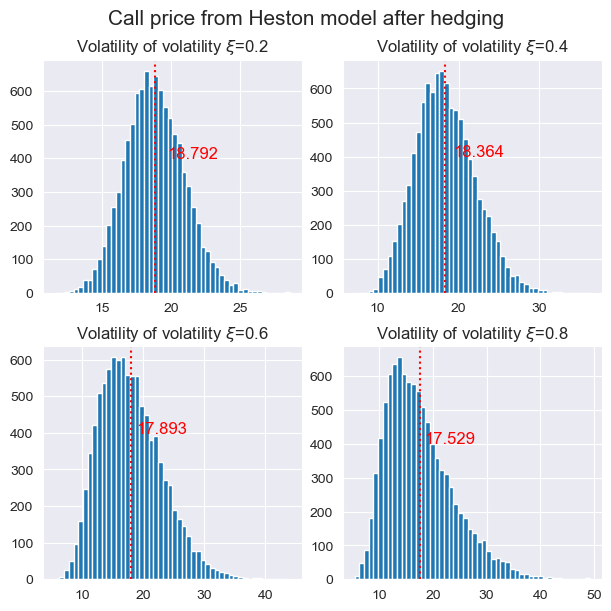

In [98]:
fig10, axs10 = plt.subplots(2, 2, figsize=[6, 6], layout='constrained')
for ax, x in zip(axs10.flat, xis):
    heston_call_price = heston_call_MC(S0, K, v0, r, t, n_steps, kappa, theta, x, rho, 10000, mu)
    heston_call_price_mean = np.mean(heston_call_price)
    ax.hist(heston_call_price, bins=50)
    ax.axvline(heston_call_price_mean, linestyle=':', color='r')
    ax.text(x=heston_call_price_mean * 1.05, y=400, s=f'{heston_call_price_mean:.3f}', color='r', fontsize=12)
    ax.set_title(f"Volatility of volatility $\\xi$={x}")
fig10.suptitle("Call price from Heston model after hedging", fontsize=15)

Noticed that when the volatility of volatility increase, the mean call option price decrease but not dramatically. The Heston model is more robust again volatility change comping to our model using a normal distribution directly. 

Text(0.5, 0.98, 'Simulated historical volatilities over 21 trading days')

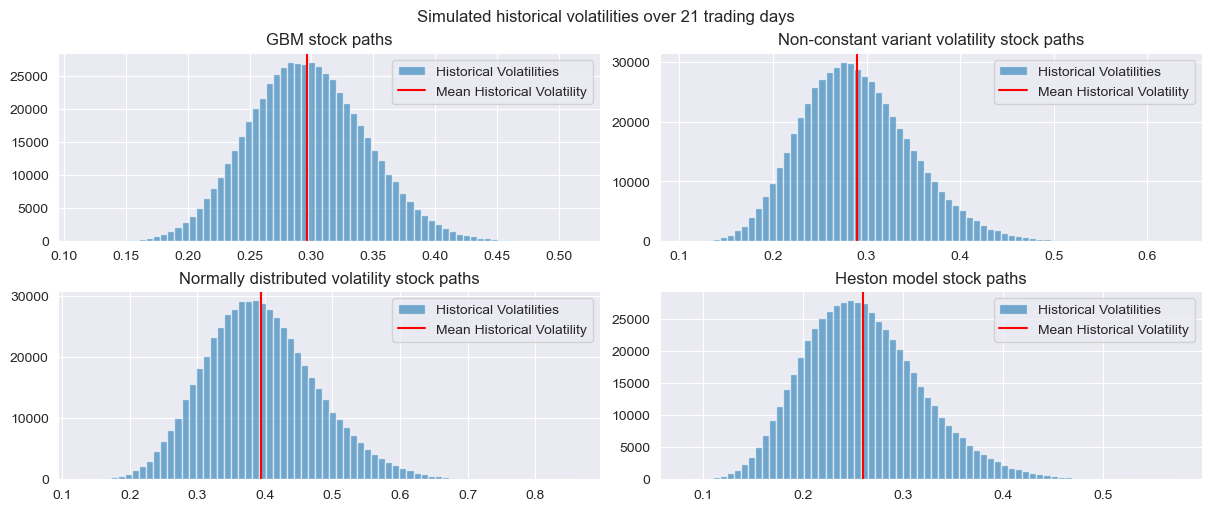

In [103]:
heston_path = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, 2500, mu)


# Convert simulated paths to pandas series
heston_path = [pd.Series(path) for path in heston_path]

# Compute 21-day volatilities of paths
heston_path_rolling_vols = [
    np.log(path / path.shift(1)).rolling(window=21).std() * np.sqrt(252)
    for path in heston_path
]

# Concatenate the rolling volatilities of the simulated paths
heston_path_all_rolling_vols = pd.concat(heston_path_rolling_vols, ignore_index=True).dropna()

# Create Histogram of volatilities
fig11, axs11 = plt.subplots(2, 2, figsize=[12, 5], layout="constrained")
axs11[0, 0].hist(bs_all_rolling_vols, bins=70, alpha=0.6, label="Historical Volatilities")
axs11[0, 0].axvline(
    np.mean(bs_all_rolling_vols), color="red", label="Mean Historical Volatility"
)
axs11[0, 0].legend()
axs11[0, 0].set_title(
    "GBM stock paths"
)
axs11[0, 1].hist(non_constant_all_rolling_vols, bins=70, alpha=0.6, label="Historical Volatilities")
axs11[0, 1].axvline(
    np.mean(non_constant_all_rolling_vols), color="red", label="Mean Historical Volatility"
)
axs11[0, 1].legend()
axs11[0, 1].set_title(
    "Non-constant variant volatility stock paths"
)
axs11[1, 0].hist(
    non_constant_normal_all_rolling_vols, bins=70, alpha=0.6, label="Historical Volatilities"
)
axs11[1, 0].axvline(
    np.mean(non_constant_normal_all_rolling_vols),
    color="red",
    label="Mean Historical Volatility",
)
axs11[1, 0].legend()
axs11[1, 0].set_title(
    "Normally distributed volatility stock paths"
)
axs11[1, 1].hist(
    heston_path_all_rolling_vols, bins=70, alpha=0.6, label="Historical Volatilities"
)
axs11[1, 1].axvline(
    np.mean(heston_path_all_rolling_vols),
    color="red",
    label="Mean Historical Volatility",
)
axs11[1, 1].legend()
axs11[1, 1].set_title(
    "Heston model stock paths"
)

fig11.suptitle("Simulated historical volatilities over 21 trading days")


The historical volatilizes histogram shows that all the non-constant volatility model we investigate here can capture the skewed feature of volatilizes changes in the real market data. This means that in reality, the stock movement have time dependent volatility and can not be simply modeled using geometric brownian motion. 